In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee

# Gaussian

In [2]:
def generate_data(factor, mean_A, scale_A, mean_B, scale_B, size):
    """
    Function to generate a Gaussian distribution with specified mean,
    scale and size. 
    """
    return factor * np.random.normal(loc=mean_A, scale=scale_A, size=size) \
                + (1 - factor) * np.random.normal(loc=mean_B, scale=scale_B, size=size)

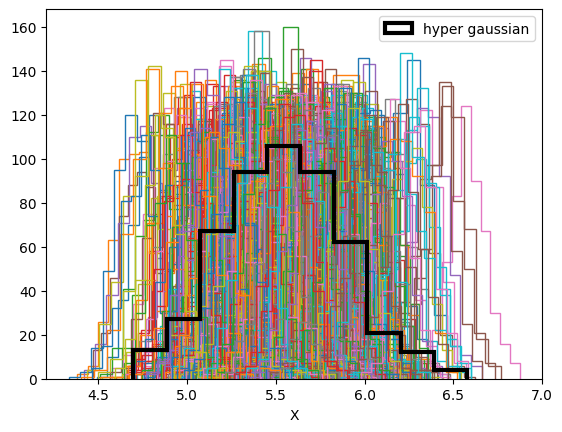

In [3]:
# True parameters for the parent + child Gaussian distribution

true_factor = .35 # hyperparameter
true_parent_A_mean = 1.0 # hyperparameter
true_parent_B_mean = 8.0 # hyperparameter
true_parent_A_scale = .4 # hyperparameter
true_parent_B_scale = .5 # hyperparameter
true_child_scale = 0.1

N_obs = 500
size_child = 500

# Hypothesis for parent gaussian 
hyper_gaussian = generate_data(true_factor,
                               true_parent_A_mean, true_parent_A_scale,
                               true_parent_B_mean, true_parent_B_scale,
                               size=N_obs)

true_gaussian = np.random.normal(loc=hyper_gaussian[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_gaussian[i], fill=False, histtype='step')
plt.hist(hyper_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=10)
plt.xlabel("X")
plt.legend()

In [4]:
def hierarchical_model(params):
    """
    Generate child data from the hierarchical model in steps 
    of first generating a parent data which then will be used 
    to generate child data.
    """
    factor, parent_A_mean, parent_A_scale, parent_B_mean, parent_B_scale = params
    parent_data = generate_data(factor, parent_A_mean, parent_A_scale, parent_B_mean, parent_B_scale, size=N_obs)
    child_data = np.random.normal(loc=parent_data[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))
    return child_data

In [5]:
def log_likelihood(params):
    # parent_mean, parent_scale = params 
    # above not required here ?
    model_data = hierarchical_model(params)
    residuals = true_gaussian - model_data
    
    # Q : is the scaling correct here ?
    
    chi_square = np.sum(residuals**2 / (2 * true_child_scale**2) + np.log(2 * np.pi * true_child_scale**2))
    #chi_square = np.sum(residuals**2)
    return - 0.5 * chi_square

def log_prior(params):
    factor, parent_A_mean, parent_A_scale, parent_B_mean, parent_B_scale = params
    # Flat priors (how to use gaussian priors ?)
    if (0 < factor < 1 and 
        0 < parent_A_mean < 10 and 
        0 < parent_A_scale < 1 and 
        0 < parent_B_mean < 10 and 
        0 < parent_B_scale < 1 ):
        
        return 0.0
    
    return -np.inf

def log_posterior(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [6]:
# Initial parameter values (guess values use of ML ?)
initial_params = [0.5, 1, .5, 1, .5]

# Number of walkers (chains) and number of steps
n_walkers = 20
n_steps = 5000

initial_positions = [initial_params + 1e-2 * np.random.randn(5) for _ in range(n_walkers)]

ndim = len(initial_params)
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior)
sampler.run_mcmc(initial_positions, n_steps, progress=True)

100%|██████████| 5000/5000 [04:54<00:00, 16.98it/s]


State([[9.98432620e-01 3.07485888e+00 9.25898432e-01 2.38598541e-02
  1.92836017e-02]
 [9.97484169e-01 2.99387985e+00 8.39823713e-01 4.77424931e-02
  9.39097408e-03]
 [9.96168515e-01 3.01754566e+00 8.89279641e-01 4.31751218e-02
  5.20948516e-02]
 [9.94563210e-01 3.02691087e+00 9.24238231e-01 6.48599157e-02
  6.03377920e-02]
 [5.08488367e-02 5.11892974e-03 9.96287314e-01 2.03462594e+00
  5.27674257e-01]
 [9.95043368e-01 3.05845856e+00 9.20693926e-01 3.51517968e-02
  2.57252844e-02]
 [5.41301262e-02 1.43503095e-03 9.99904027e-01 2.08834634e+00
  4.38239706e-01]
 [5.38416977e-02 1.29791459e-04 9.99344674e-01 2.08754150e+00
  4.38976779e-01]
 [9.99808401e-01 3.04194523e+00 8.74142324e-01 2.55202882e-03
  9.40855699e-03]
 [9.98627512e-01 3.02430467e+00 8.82423069e-01 7.21663378e-02
  1.08284503e-02]
 [9.97057988e-01 3.01580761e+00 8.75892640e-01 4.23920977e-02
  2.76292150e-02]
 [9.97592216e-01 3.07544361e+00 9.93573124e-01 1.08846191e-01
  6.88410343e-02]
 [9.97025481e-01 3.12179439e+00 9.

Text(0.5, 0, 'step number')

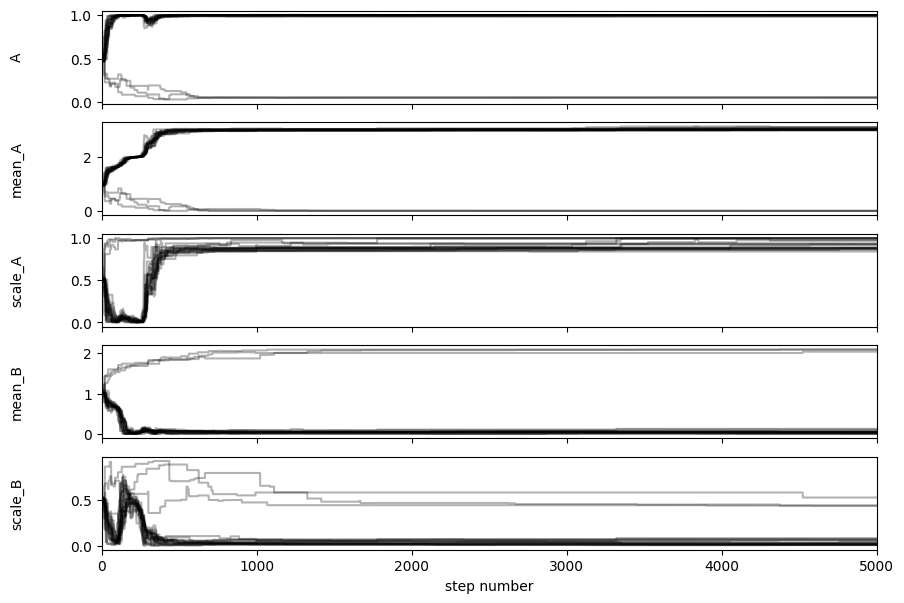

In [9]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","mean_A","scale_A", "mean_B", "scale_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [104.5863635  334.90846331 324.53020782 210.48677974 267.08032075]

In [11]:
flat_samples = sampler.get_chain(discard=500, thin=5, flat=True) 
print(flat_samples.shape)

(18000, 5)


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


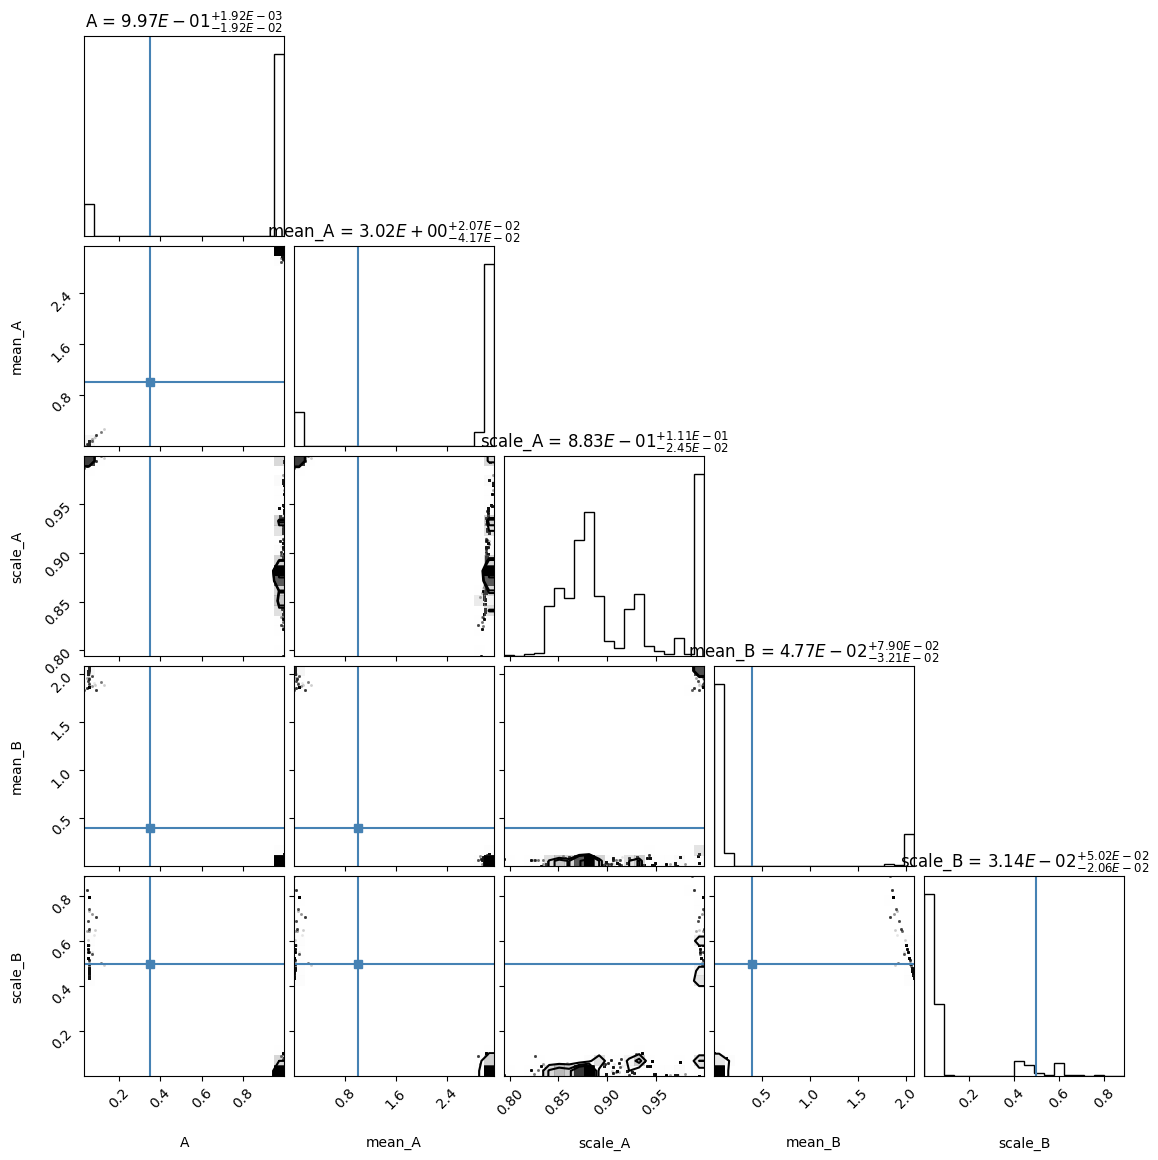

In [12]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_factor, true_parent_A_mean, true_parent_B_mean, true_parent_A_scale, true_parent_B_scale],
    title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)